## Review data

In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
def set_seed(seed=42):
    random.seed(seed)                    
    np.random.seed(seed)                 
    torch.manual_seed(seed)              
    torch.cuda.manual_seed(seed)         
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
data_path = 'archive/samples'

In [4]:
images = os.listdir(data_path)

(50, 200, 3)


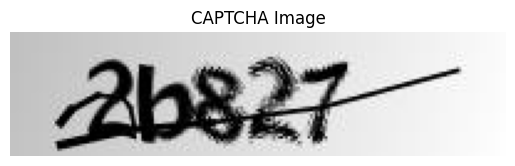

In [5]:
img_path = 'archive/samples/2b827.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

plt.imshow(img)
plt.axis('off') 
plt.title("CAPTCHA Image")
plt.show()

In [6]:
labels = [img.split(os.path.sep)[-1].split(".")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  1070
Number of labels found:  1070
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


## Preprocessing and split data

In [7]:
characters = ["-"] + characters
# Mapping characters to integers
char_to_num = {char: idx for idx, char in enumerate(characters)}

# Mapping integers back to original characters
num_to_char = {idx: char for char, idx in char_to_num.items()}

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

In [8]:
class OCRDataset(Dataset):
    def __init__(self, image_paths, labels, img_width, img_height, char_to_idx):
        self.image_paths = image_paths
        self.labels = labels
        self.img_width = img_width
        self.img_height = img_height
        self.char_to_idx = char_to_idx

        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((self.img_height, self.img_width)),
            transforms.ToTensor(), 
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        image = image.permute(0, 2, 1)

        label_encoded = torch.tensor([self.char_to_idx[c] for c in label], dtype=torch.long)

        return {
            "image": image,             
            "label": label_encoded,     
            "label_str": label,        
        }

In [9]:
train_paths = []
for image in X_train:
    image_path = os.path.join(data_path, image)
    train_paths.append(image_path)

val_paths = []
for image in X_val:
    image_path = os.path.join(data_path, image)
    val_paths.append(image_path)

test_paths = []
for image in X_test:
    image_path = os.path.join(data_path, image)
    test_paths.append(image_path)

train_dataset = OCRDataset(train_paths, y_train, img_width=200, img_height=50, char_to_idx=char_to_num)
val_dataset = OCRDataset(val_paths, y_val, img_width=200, img_height=50, char_to_idx=char_to_num)
test_dataset = OCRDataset(test_paths, y_test, img_width=200, img_height=50, char_to_idx=char_to_num)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Define model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
class OCRModel(nn.Module):
    def __init__(self, num_classes):
        super(OCRModel, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (B, 32, 200, 50)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # (B, 32, 100, 25)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (B, 64, 100, 25)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # (B, 64, 50, 12)
        )

        self.linear1 = nn.Linear(64 * 12, 64)

        self.lstm1 = nn.LSTM(64, 128, bidirectional=True, batch_first=True)  # (B, T, 128)
        self.dropout1 = nn.Dropout(0.25)
        self.lstm2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True)  # (B, T, 128)
        self.dropout2 = nn.Dropout(0.25)

        self.classifier = nn.Linear(128, num_classes)  # 64 * 2 (bi-directional)

    def forward(self, x):
        x = self.cnn(x)                   # (B, C, W, H) = (B, 64, 50, 12)
        x = x.permute(0, 2, 3, 1)         # (B, W, H, C) = (B, 50, 12, 64)
        x = x.reshape(x.size(0), x.size(1), -1) # (B, W, H * C) = (B, 50, 768)
        x = self.linear1(x)              # (B, W, 64)
        x = nn.Dropout(0.2)(x)            # (B, W, 64)

        x, _ = self.lstm1(x)             # (B, W, 256)
        x = self.dropout1(x)              # (B, W, 256)
        x, _ = self.lstm2(x)             # (B, W, 128)
        x = self.dropout2(x)              # (B, W, 128)

        x = self.classifier(x)           # (B, W, num_classes)
        x = F.log_softmax(x, dim=2)      # for CTC loss

        x = x.permute(1, 0, 2)           # (T, B, C)
        return x

In [13]:
model = OCRModel(num_classes=len(characters)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CTCLoss(blank=0).to(device)
summary(model, input_size=(32, 1, 200, 50))

Layer (type:depth-idx)                   Output Shape              Param #
OCRModel                                 [50, 32, 20]              --
├─Sequential: 1-1                        [32, 64, 50, 12]          --
│    └─Conv2d: 2-1                       [32, 32, 200, 50]         320
│    └─ReLU: 2-2                         [32, 32, 200, 50]         --
│    └─MaxPool2d: 2-3                    [32, 32, 100, 25]         --
│    └─Conv2d: 2-4                       [32, 64, 100, 25]         18,496
│    └─ReLU: 2-5                         [32, 64, 100, 25]         --
│    └─MaxPool2d: 2-6                    [32, 64, 50, 12]          --
├─Linear: 1-2                            [32, 50, 64]              49,216
├─LSTM: 1-3                              [32, 50, 256]             198,656
├─Dropout: 1-4                           [32, 50, 256]             --
├─LSTM: 1-5                              [32, 50, 128]             164,864
├─Dropout: 1-6                           [32, 50, 128]            

## Train model

In [14]:
def train(model, train_loader, val_loader, optimizer, criterion, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True):
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            labels_flat = labels.view(-1)

            optimizer.zero_grad()
            outputs = model(images)
            T = outputs.size(0)
            B = outputs.size(1)

            label_lengths = torch.full((B,), labels.size(1), dtype=torch.long).to(device)
            image_lengths = torch.full((B,), T, dtype=torch.long).to(device)

            loss = criterion(outputs, labels_flat, image_lengths, label_lengths)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation", leave=True):
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                labels_flat = labels.view(-1)
            
                outputs = model(images)
                T = outputs.size(0)
                B = outputs.size(1)

                label_lengths = torch.full((B,), labels.size(1), dtype=torch.long).to(device)
                image_lengths = torch.full((B,), T, dtype=torch.long).to(device)

                loss = criterion(outputs, labels_flat, image_lengths, label_lengths)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1: Train Loss = 8.9975, Val Loss = 3.6842


Epoch 2/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2: Train Loss = 3.3261, Val Loss = 3.2731


Epoch 3/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 3: Train Loss = 3.2687, Val Loss = 3.2711


Epoch 4/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 4: Train Loss = 3.2665, Val Loss = 3.2774


Epoch 5/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 5: Train Loss = 3.2688, Val Loss = 3.2759


Epoch 6/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 6: Train Loss = 3.2654, Val Loss = 3.2792


Epoch 7/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 7: Train Loss = 3.2652, Val Loss = 3.2761


Epoch 8/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 8: Train Loss = 3.2682, Val Loss = 3.2767


Epoch 9/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 9: Train Loss = 3.2690, Val Loss = 3.2767


Epoch 10/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: Train Loss = 3.2661, Val Loss = 3.2774


Epoch 11/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: Train Loss = 3.2698, Val Loss = 3.2760


Epoch 12/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: Train Loss = 3.2665, Val Loss = 3.2752


Epoch 13/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: Train Loss = 3.2679, Val Loss = 3.2770


Epoch 14/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: Train Loss = 3.2660, Val Loss = 3.2790


Epoch 15/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: Train Loss = 3.2641, Val Loss = 3.2764


Epoch 16/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: Train Loss = 3.2672, Val Loss = 3.2745


Epoch 17/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: Train Loss = 3.2688, Val Loss = 3.2796


Epoch 18/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: Train Loss = 3.2670, Val Loss = 3.2748


Epoch 19/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: Train Loss = 3.2675, Val Loss = 3.2763


Epoch 20/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: Train Loss = 3.2667, Val Loss = 3.2759


Epoch 21/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: Train Loss = 3.2663, Val Loss = 3.2772


Epoch 22/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: Train Loss = 3.2677, Val Loss = 3.2756


Epoch 23/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: Train Loss = 3.2662, Val Loss = 3.2778


Epoch 24/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: Train Loss = 3.2659, Val Loss = 3.2770


Epoch 25/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: Train Loss = 3.2674, Val Loss = 3.2749


Epoch 26/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: Train Loss = 3.2656, Val Loss = 3.2760


Epoch 27/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: Train Loss = 3.2653, Val Loss = 3.2784


Epoch 28/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: Train Loss = 3.2678, Val Loss = 3.2711


Epoch 29/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: Train Loss = 3.2643, Val Loss = 3.2796


Epoch 30/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: Train Loss = 3.2646, Val Loss = 3.2776


Epoch 31/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: Train Loss = 3.2629, Val Loss = 3.2752


Epoch 32/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: Train Loss = 3.2643, Val Loss = 3.2817


Epoch 33/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: Train Loss = 3.2649, Val Loss = 3.2759


Epoch 34/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: Train Loss = 3.2667, Val Loss = 3.2758


Epoch 35/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: Train Loss = 3.2654, Val Loss = 3.2777


Epoch 36/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: Train Loss = 3.2662, Val Loss = 3.2781


Epoch 37/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: Train Loss = 3.2628, Val Loss = 3.2764


Epoch 38/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: Train Loss = 3.2616, Val Loss = 3.2807


Epoch 39/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: Train Loss = 3.2632, Val Loss = 3.2720


Epoch 40/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: Train Loss = 3.2602, Val Loss = 3.2750


Epoch 41/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: Train Loss = 3.2573, Val Loss = 3.2778


Epoch 42/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: Train Loss = 3.2596, Val Loss = 3.2698


Epoch 43/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: Train Loss = 3.2576, Val Loss = 3.2683


Epoch 44/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: Train Loss = 3.2557, Val Loss = 3.2654


Epoch 45/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: Train Loss = 3.2419, Val Loss = 3.2528


Epoch 46/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: Train Loss = 3.2128, Val Loss = 3.1946


Epoch 47/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: Train Loss = 3.1505, Val Loss = 3.0810


Epoch 48/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: Train Loss = 2.9749, Val Loss = 2.8390


Epoch 49/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: Train Loss = 2.7241, Val Loss = 2.5209


Epoch 50/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: Train Loss = 2.3900, Val Loss = 2.1657


Epoch 51/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 51: Train Loss = 1.9234, Val Loss = 1.6242


Epoch 52/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 52: Train Loss = 1.4253, Val Loss = 1.1873


Epoch 53/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 53: Train Loss = 1.0169, Val Loss = 0.7651


Epoch 54/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 54: Train Loss = 0.7427, Val Loss = 0.5619


Epoch 55/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 55: Train Loss = 0.5524, Val Loss = 0.4291


Epoch 56/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 56: Train Loss = 0.4198, Val Loss = 0.3127


Epoch 57/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 57: Train Loss = 0.3389, Val Loss = 0.2621


Epoch 58/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 58: Train Loss = 0.2781, Val Loss = 0.2177


Epoch 59/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 59: Train Loss = 0.2329, Val Loss = 0.1834


Epoch 60/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 60: Train Loss = 0.2055, Val Loss = 0.1621


Epoch 61/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 61: Train Loss = 0.1785, Val Loss = 0.1582


Epoch 62/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 62: Train Loss = 0.1555, Val Loss = 0.1261


Epoch 63/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 63: Train Loss = 0.1398, Val Loss = 0.1097


Epoch 64/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 64: Train Loss = 0.1104, Val Loss = 0.0850


Epoch 65/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 65: Train Loss = 0.0962, Val Loss = 0.0690


Epoch 66/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 66: Train Loss = 0.0751, Val Loss = 0.0497


Epoch 67/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 67: Train Loss = 0.0666, Val Loss = 0.0432


Epoch 68/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 68: Train Loss = 0.0537, Val Loss = 0.0395


Epoch 69/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 69: Train Loss = 0.0485, Val Loss = 0.0410


Epoch 70/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 70: Train Loss = 0.0457, Val Loss = 0.0411


Epoch 71/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 71: Train Loss = 0.0384, Val Loss = 0.0374


Epoch 72/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 72: Train Loss = 0.0392, Val Loss = 0.0284


Epoch 73/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 73: Train Loss = 0.0315, Val Loss = 0.0319


Epoch 74/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 74: Train Loss = 0.0322, Val Loss = 0.0234


Epoch 75/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 75: Train Loss = 0.0290, Val Loss = 0.0216


Epoch 76/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 76: Train Loss = 0.0242, Val Loss = 0.0177


Epoch 77/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 77: Train Loss = 0.0231, Val Loss = 0.0179


Epoch 78/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 78: Train Loss = 0.0209, Val Loss = 0.0236


Epoch 79/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 79: Train Loss = 0.0194, Val Loss = 0.0135


Epoch 80/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 80: Train Loss = 0.0209, Val Loss = 0.0229


Epoch 81/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 81: Train Loss = 0.0173, Val Loss = 0.0159


Epoch 82/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 82: Train Loss = 0.0253, Val Loss = 0.0231


Epoch 83/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 83: Train Loss = 0.0186, Val Loss = 0.0101


Epoch 84/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 84: Train Loss = 0.0210, Val Loss = 0.0116


Epoch 85/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 85: Train Loss = 0.0181, Val Loss = 0.0226


Epoch 86/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 86: Train Loss = 0.0146, Val Loss = 0.0161


Epoch 87/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 87: Train Loss = 0.0143, Val Loss = 0.0141


Epoch 88/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 88: Train Loss = 0.0161, Val Loss = 0.0367


Epoch 89/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 89: Train Loss = 0.0239, Val Loss = 0.0281


Epoch 90/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 90: Train Loss = 0.0220, Val Loss = 0.0181


Epoch 91/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 91: Train Loss = 0.0162, Val Loss = 0.0130


Epoch 92/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 92: Train Loss = 0.0122, Val Loss = 0.0060


Epoch 93/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 93: Train Loss = 0.0098, Val Loss = 0.0089


Epoch 94/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 94: Train Loss = 0.0084, Val Loss = 0.0079


Epoch 95/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 95: Train Loss = 0.0126, Val Loss = 0.0221


Epoch 96/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 96: Train Loss = 0.0230, Val Loss = 0.0115


Epoch 97/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 97: Train Loss = 0.0123, Val Loss = 0.0108


Epoch 98/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 98: Train Loss = 0.0106, Val Loss = 0.0065


Epoch 99/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 99: Train Loss = 0.0082, Val Loss = 0.0056


Epoch 100/100:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 100: Train Loss = 0.0074, Val Loss = 0.0092


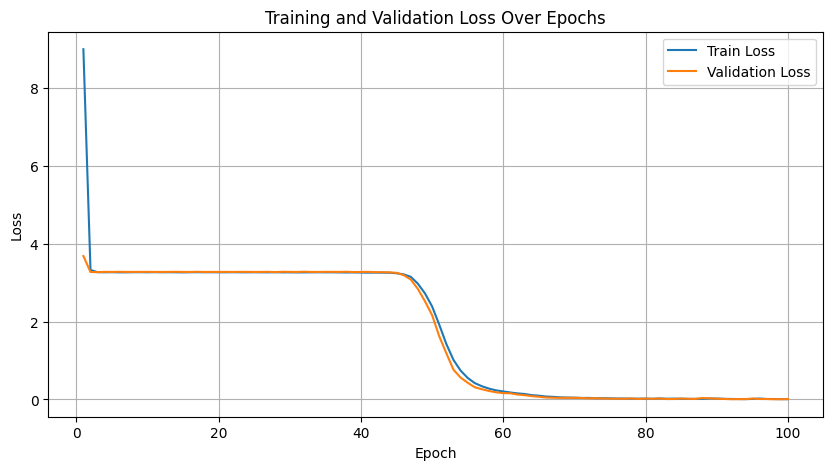

In [15]:
train(model, train_loader, val_loader, optimizer, criterion, num_epochs=100)

In [16]:
torch.save(model.state_dict(), "ocr_model.pth")

In [17]:
model = OCRModel(num_classes=len(characters)).to(device)
model.load_state_dict(torch.load("ocr_model.pth"))

C:\Users\Admin\AppData\Local\Temp\ipykernel_26232\1564037265.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ocr_model.pth"))


<All keys matched successfully>

## Predictions

In [18]:
def decode_ctc(output, num_to_char):
    out = output.permute(1, 0, 2)
    out_decoded = []
    for logits in out:
        pred = torch.argmax(logits, dim=-1)
        prev = -1
        decoded = []
        for p in pred:
            if p.item() != prev and p.item() != 0:
                decoded.append(num_to_char[p.item()])
            prev = p.item()
        out_decoded.append("".join(decoded))
    return out_decoded 
    

In [19]:
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images)
        predictions = decode_ctc(outputs, num_to_char)

        for lbl in labels:
            label_str = ''.join([num_to_char[i.item()] for i in lbl])
            all_labels.append(label_str)

        all_predictions.extend(predictions)

## Inference

Predicted: 37ep6, Actual: 37ep6


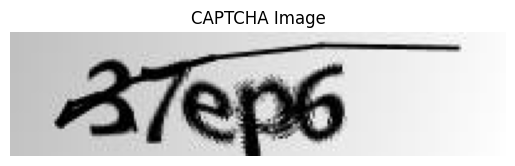

Predicted: 3den6, Actual: 3den6


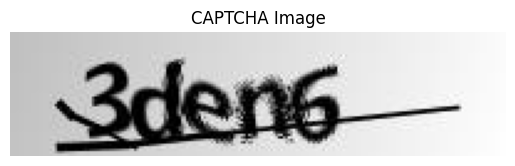

Predicted: eng53, Actual: eng53


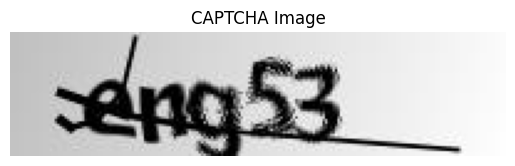

Predicted: 7xcyd, Actual: 7xcyd


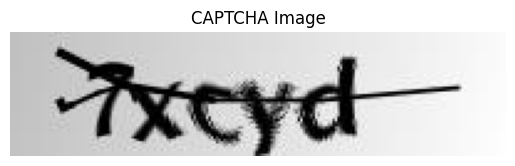

Predicted: x76mn, Actual: x76mn


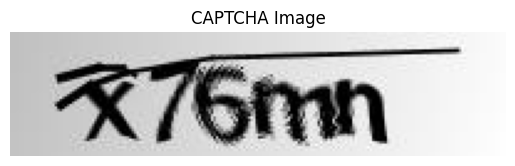

Predicted: 5expp, Actual: 5expp


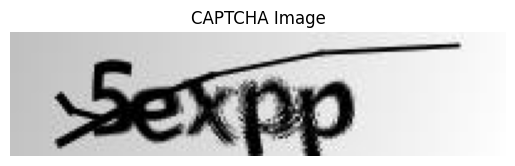

Predicted: d7en3, Actual: d7en3


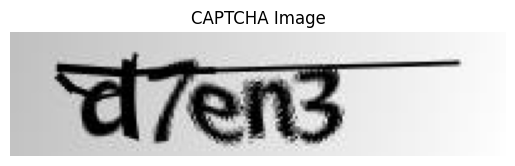

Predicted: gc2wd, Actual: gc2wd


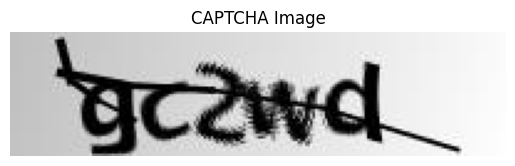

Predicted: 3bfnd, Actual: 3bfnd


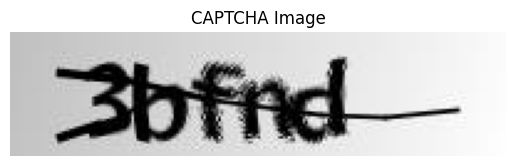

Predicted: 2n73f, Actual: 2n73f


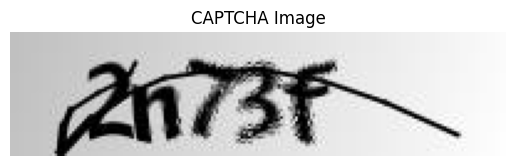

In [20]:
for i in range(10):
    print(f"Predicted: {all_predictions[i]}, Actual: {all_labels[i]}")
    plt.imshow(cv2.imread(test_paths[i]))
    plt.axis('off') 
    plt.title("CAPTCHA Image")
    plt.show()

## False Predictions

Mismatch at index 64: Predicted: cd5p4, Actual: cd6p4


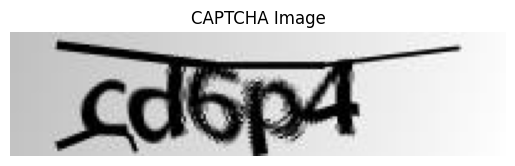

Mismatch at index 67: Predicted: fxx25, Actual: nxx25


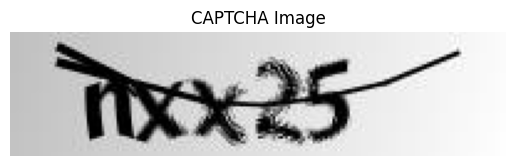

Mismatch at index 76: Predicted: 75w8, Actual: w75w8


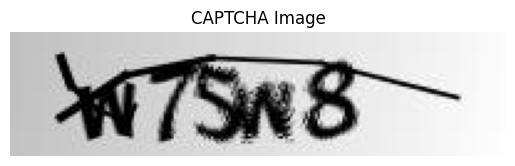

Mismatch at index 98: Predicted: pc8c, Actual: cpc8c


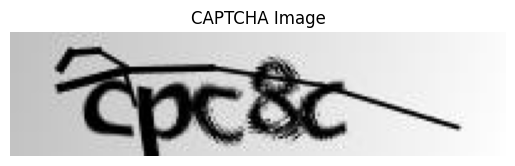

Mismatch at index 100: Predicted: bcpg6, Actual: pcpg6


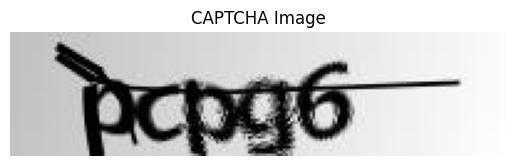

In [21]:
for i in range(len(all_predictions)):
    if all_predictions[i] != all_labels[i]:
        print(f"Mismatch at index {i}: Predicted: {all_predictions[i]}, Actual: {all_labels[i]}")
        plt.imshow(cv2.imread(test_paths[i]))
        plt.axis('off') 
        plt.title("CAPTCHA Image")
        plt.show()

## Evaluation

In [22]:
def compute_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
        return np.sum(predictions == groundtruth)/(len(predictions))
    else:
        raise Exception('Error : the size of the arrays do not match. Cannot compute the performance metric')

In [23]:
import editdistance

def cer(pred_str, true_str):
    return editdistance.eval(pred_str, true_str) / len(true_str)

In [24]:
compute_metric(np.array(all_predictions), np.array(all_labels))

0.968944099378882

In [25]:
cer(all_predictions, all_labels)

0.031055900621118012